In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import glob
import torch
from torch.utils.data import DataLoader
import warnings
warnings.simplefilter("ignore", np.RankWarning)

import sys

sys.path.append("../filters-models")
from Convolutional_Mormyromast import ConvMormyromast
from lfp_response_dataset import create_train_and_validation_datasets

# Stimuli

## Example stimuli delivered

In [2]:
lfp_data = pd.read_pickle('../data/lfp-abby/processed/trial_averages.pkl')
select_stimuli = np.vstack(lfp_data[(lfp_data["fish_id"] == "fish_01") & (lfp_data["zone"] == "mz")]["waveform"]).T
base_stimulus = lfp_data["base_waveform"].iloc[0]
sampling_rate = lfp_data["stimulus_sampling_rate"].iloc[0]

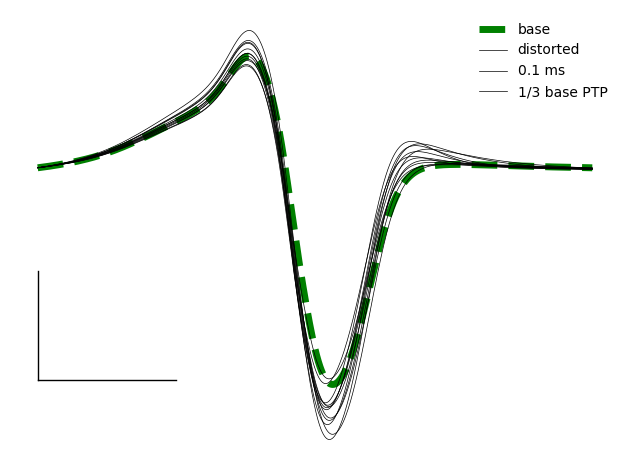

In [3]:
plt.figure()
plt.plot(base_stimulus, "green", ls="--", lw=5)
plt.plot(select_stimuli[:, ::20], "k", lw=0.5)
plt.plot([0, 0.1e-3 * sampling_rate], [-1, -1], "k", lw=1)
plt.plot([0, 0], [-1, -1 + base_stimulus.ptp()/3], "k", lw=1)
plt.legend(["base", "distorted", "0.1 ms", "1/3 base PTP"], loc=1, frameon=False)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.tight_layout()
plt.savefig("./panels/example_stimuli.svg")
plt.show()

## Delivered vs. recorded stimuli

In [4]:
stimulus_delivery_data = pd.read_pickle('../data/stimulus-delivery-nate/processed/delivered-vs-recorded.pkl')

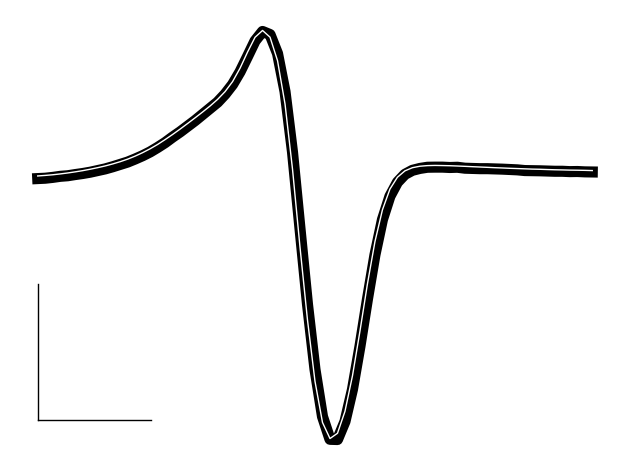

In [5]:
id = 0

dfrow = stimulus_delivery_data.iloc[id]

plt.figure()
# plt.plot(dfrow["stimulus_time"]*1e3, dfrow["stimulus"], label="stimulus", color='k', lw=8)
plt.plot(dfrow["recording_digital_time"]*1e3, dfrow["recording_digital"], label="stimulus", color='k', lw=8)
plt.plot(dfrow["recording_real_time"]*1e3, dfrow["recording_real"], label="stimulus", color='w', lw=1)
# plt.plot(dfrow["stimulus_time"]*1e3, dfrow["recording_real_interpolated"], label="interpolated", color='w', lw=1)

plt.plot([0, 0.1], [-0.6, -0.6], "k", lw=1)
plt.plot([0, 0], [-0.6, -0.6 + dfrow["recording_digital"].ptp()/3], "k", lw=1)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.tight_layout()
plt.savefig("./panels/delivered_vs_recorded_example.svg")
plt.show()

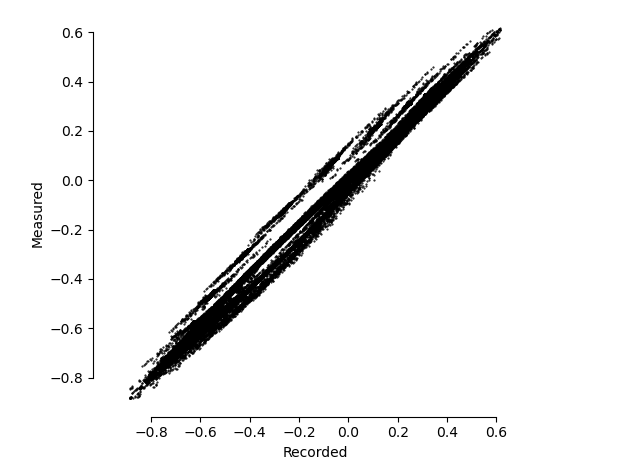

In [6]:
xs = np.hstack(stimulus_delivery_data["recording_digital"])
ys = np.hstack(stimulus_delivery_data["recording_real"])

fig = plt.figure()
plt.scatter(xs, ys, marker=".", color="k", s=1)
plt.axis("equal")
plt.xlabel("Recorded")
plt.ylabel("Measured")
sns.despine(offset={"left": -60}, trim=True)
plt.tight_layout()
plt.savefig("./panels/delivered_vs_recorded_scatter.svg")
# fig.set_size_inches(20, 20)
plt.savefig("./panels/delivered_vs_recorded_scatter.png", dpi=1000)
plt.show()

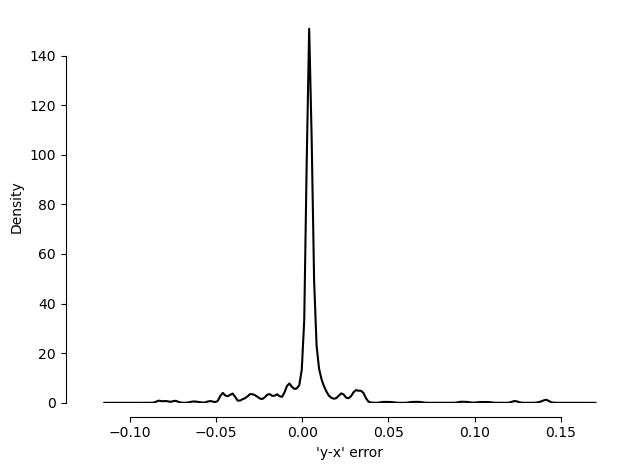

In [7]:
plt.figure()
sns.kdeplot(ys-xs, color='k')
sns.despine(offset=10, trim=True)
plt.xlabel("'y-x' error")
plt.tight_layout()
plt.savefig("./panels/delivered_vs_recorded_error-kdeplot.svg")
plt.show()

## LFP for MZ and DLZ

In [8]:
lfp_data = pd.read_pickle("../data/lfp-abby/processed/trial_averages.pkl")
lfp_data = lfp_data[lfp_data["fish_id"] == "fish_09"]
lfp_sampling_rate = lfp_data["lfp_sampling_rate"].iloc[0]
cmap = plt.cm.viridis  # type: ignore

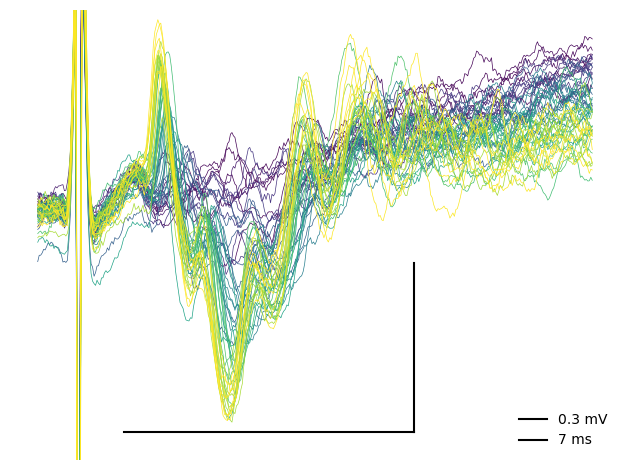

DLZ modulations: -0.142 to 0.000


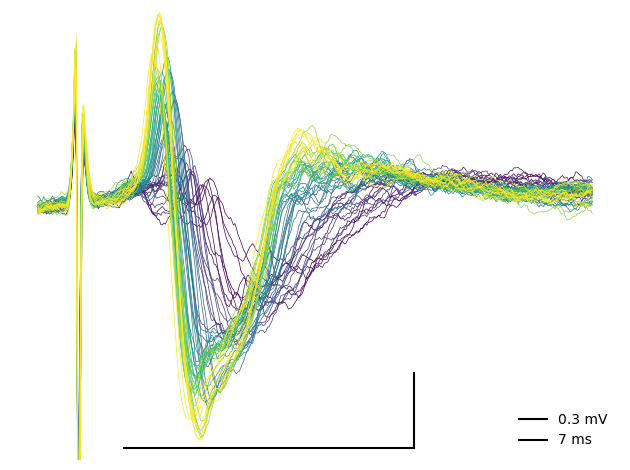

MZ modulations: -0.100 to 0.201


Empty DataFrame
Columns: []
Index: []

In [9]:
def plot_lfp_traces(dfgroup, cmap=cmap, lfp_sampling_rate=lfp_sampling_rate):
    plt.figure()
    zone = dfgroup["zone"].iloc[0]
    lfp_traces = np.vstack(
        dfgroup["lfp_trace"].apply(lambda x: x[0][7])
    )  # arbitrarily choose the 0th bout and 7th trial
    if zone == "dlz":
        modulations = np.hstack(dfgroup["stimulus_waveform_modulation_x"])
        plt.ylim(-0.4, 0.4)
        plt.plot(
            [30 + 8e-3 * lfp_sampling_rate, 30 + 8e-3 * lfp_sampling_rate],
            [-0.35, -0.05],
            "k",
            label="0.3 mV",
        )
        plt.plot([30 + 1e-3 * lfp_sampling_rate, 30 + 8e-3 * lfp_sampling_rate], [-0.35, -0.35], "k", label="7 ms")
    elif zone == "mz":
        modulations = np.hstack(dfgroup["stimulus_amplitude_modulation_x"])
        plt.plot(
            [30 + 8e-3 * lfp_sampling_rate, 30 + 8e-3 * lfp_sampling_rate],
            [-0.9, -0.6],
            "k",
            label="0.3 mV",
        )
        plt.plot([30 + 1e-3 * lfp_sampling_rate, 30 + 8e-3 * lfp_sampling_rate], [-0.9, -0.9], "k", label="7 ms")
        plt.ylim(-0.95, 0.85)
    sort_order = np.argsort(modulations)
    lfp_traces = lfp_traces[sort_order]
    modulations = modulations[sort_order]
    color_norm = mpl.colors.Normalize(vmin=modulations.min(), vmax=modulations.max())  # type: ignore
    for i in range(0, lfp_traces.shape[0], 1):
        plt.plot(lfp_traces[i][225:600], color=cmap(color_norm(modulations[i])), lw=0.5)
    plt.legend(loc=4, frameon=False)
    plt.xticks([])
    plt.yticks([])
    plt.box(False)
    plt.tight_layout()
    plt.savefig(f"./panels/lfp_traces_{zone}.svg")
    plt.show()
    print(f"{zone.upper()} modulations: {modulations.min():.3f} to {modulations.max():.3f}")


lfp_data.groupby("zone").apply(plot_lfp_traces)

## Alignment with PP and P/N

In [10]:
lfp_data = pd.read_pickle("../data/lfp-abby/processed/trial_averages.pkl")
cmap = plt.cm.plasma  # type: ignore

In [27]:
def plot_alignment_heatmap(dfgroup, cmap=cmap, inverse_arrow_length=0.1, arrow_width=0.5, num_bins=6):
    fish_id = dfgroup["fish_id"].iloc[0]
    session_id = dfgroup["session_id"].iloc[0]
    zone = dfgroup["zone"].iloc[0]
    xs = np.hstack(dfgroup["stimulus_amplitude_modulation_x"]) * 100
    ys = np.hstack(dfgroup["stimulus_waveform_modulation_x"]) * 100
    responses = dfgroup["mean_lfp_response_modulation"] * 100
    reg = LinearRegression().fit(np.stack([xs, ys]).T, responses)
    # grad_vec = reg.coef_ / np.linalg.norm(reg.coef_)
    
    xs_bins = np.linspace(xs.min(), xs.max(), num_bins+1)
    gradients_ys = []
    for x_min, x_max in zip(xs_bins[:-1], xs_bins[1:]):
        mask = (xs >= x_min) & (xs < x_max)
        gradients_ys.append(np.polyfit(ys[mask], responses[mask], 1)[0])
        
    ys_bins = np.linspace(ys.min(), ys.max(), num_bins+1)
    gradients_xs = []
    for y_min, y_max in zip(ys_bins[:-1], ys_bins[1:]):
        mask = (ys >= y_min) & (ys < y_max)
        gradients_xs.append(np.polyfit(xs[mask], responses[mask], 1)[0])
    
    grad_vec = np.array([np.mean(gradients_xs), np.mean(gradients_ys)])
    grad_vec /= np.linalg.norm(grad_vec)  
    
    color_norm = mpl.colors.Normalize(vmin=responses.min(), vmax=responses.max())  # type: ignore
    fig = plt.figure()
    plt.scatter(xs, ys, c=cmap(color_norm(responses)), s=100, marker="o")
    cbar = fig.colorbar(
        plt.cm.ScalarMappable(norm=color_norm, cmap=cmap),
        ax=plt.gca(),
        shrink=0.5,
        label="Mean LFP Response Modulation (%)",
    )
    sns.despine(ax=cbar.ax, left=False, bottom=False)
    x0, y0 = 0, 0
    if zone == "mz":
        x0 = plt.gca().get_xlim()[0]
        y0 = np.mean(plt.gca().get_ylim())
        inverse_arrow_length /= 2
    elif zone == "dlz":
        x0 = np.mean(plt.gca().get_xlim())
        y0 = plt.gca().get_ylim()[0]
    plt.arrow(
        x0,  # type: ignore
        y0,  # type: ignore
        grad_vec[0] / inverse_arrow_length,
        grad_vec[1] / inverse_arrow_length,
        facecolor="y",
        width=arrow_width,
        edgecolor="k",
        lw=1,
    )
    sns.despine(offset={"bottom": -35, "left": 10}, trim=True)
    plt.xlabel("Amplitude Modulation (%)")
    plt.ylabel("Waveform Modulation (%)")
    plt.axis("equal")
    plt.tight_layout()
    plt.title(f"{fish_id} {zone.upper()} {session_id}")
    plt.savefig(f"./panels/response_heatmap-{zone}-{fish_id}-{session_id}.svg")
    plt.show()
    return pd.Series(
        dict(
            grad_angle=np.arctan2(grad_vec[1], grad_vec[0]) * 360 / (2 * np.pi),
            grad_vec=grad_vec,
            reg_r2=reg.score(np.stack([xs, ys]).T, responses),
            all_angles=np.arctan2(gradients_ys, gradients_xs) * 360 / (2 * np.pi),
        )
    )

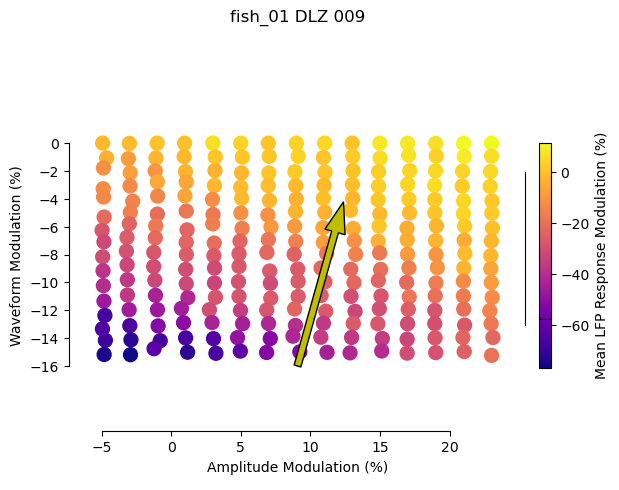

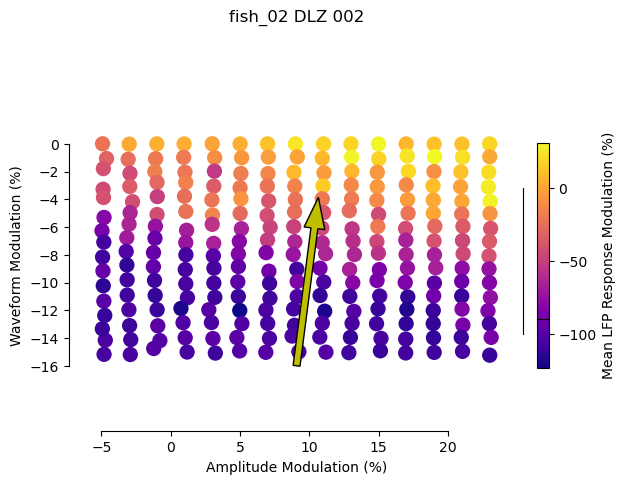

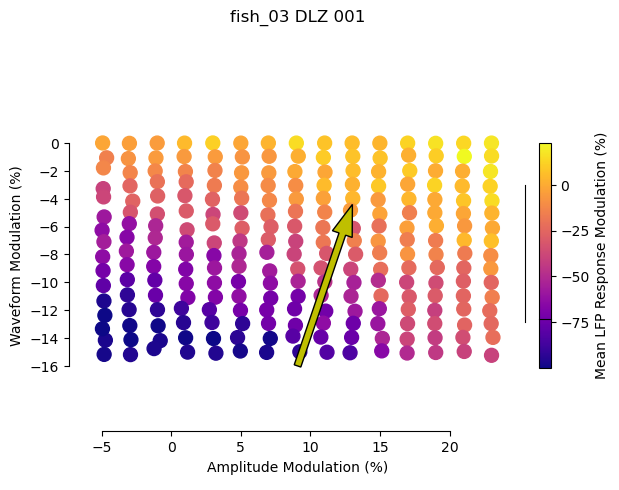

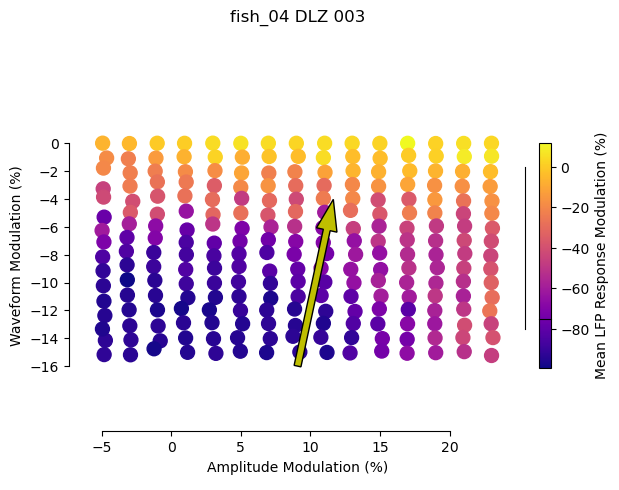

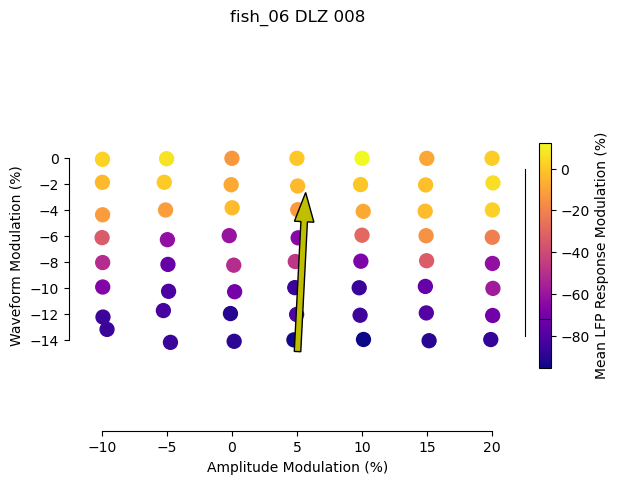

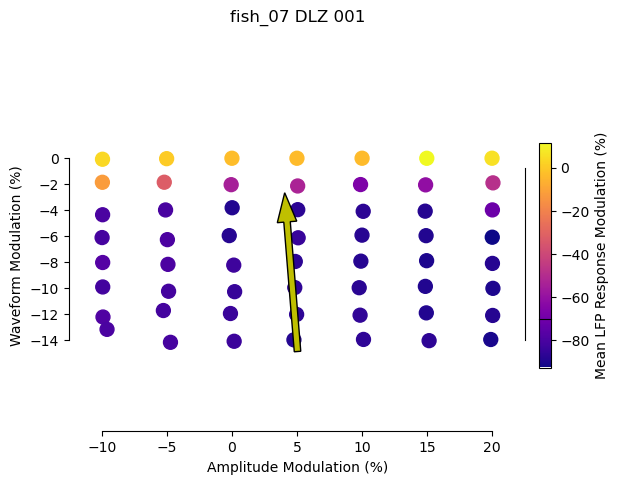

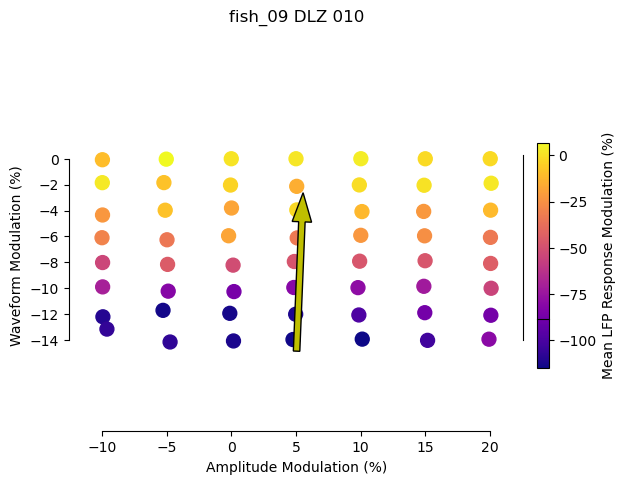

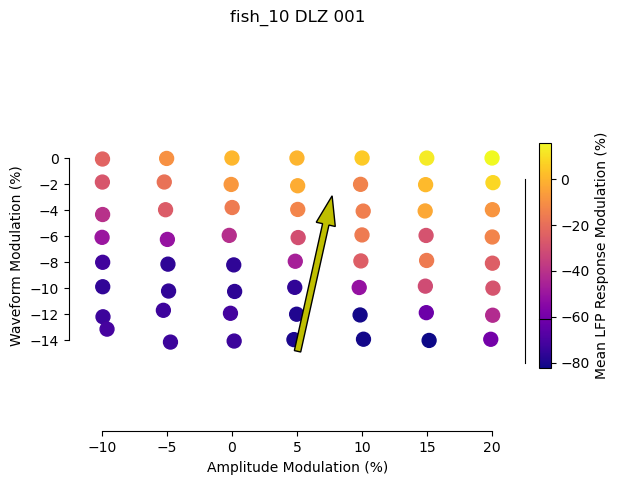

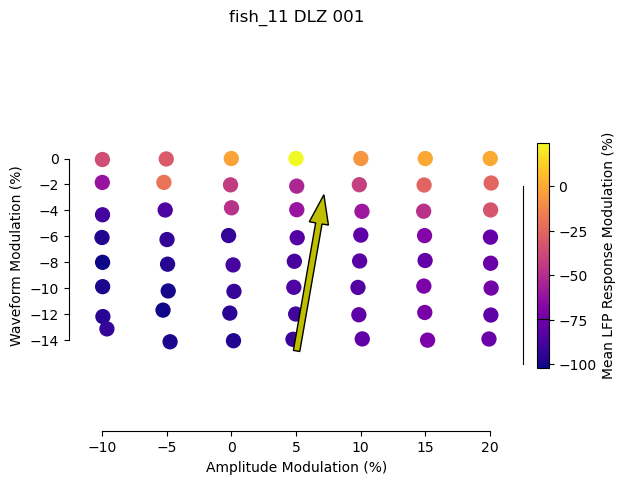

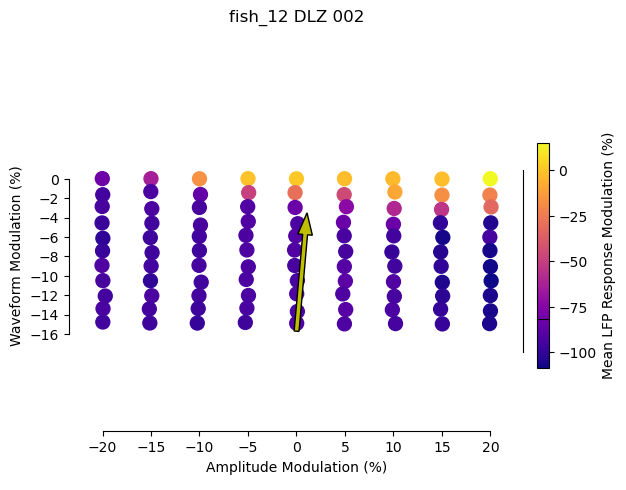

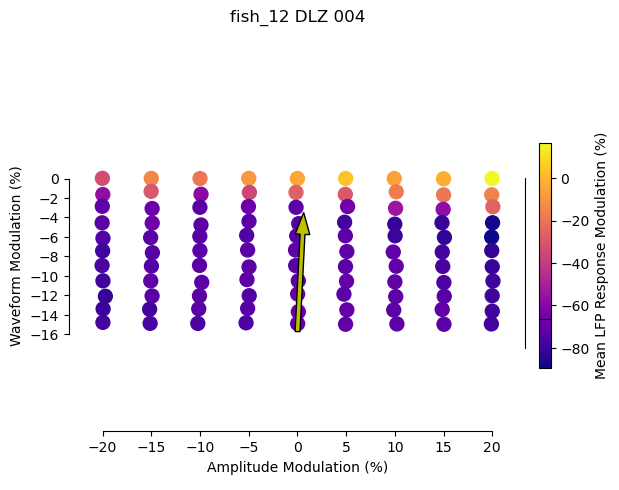

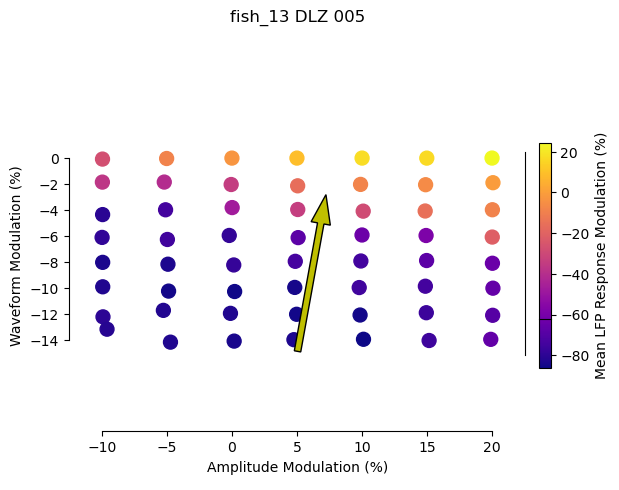

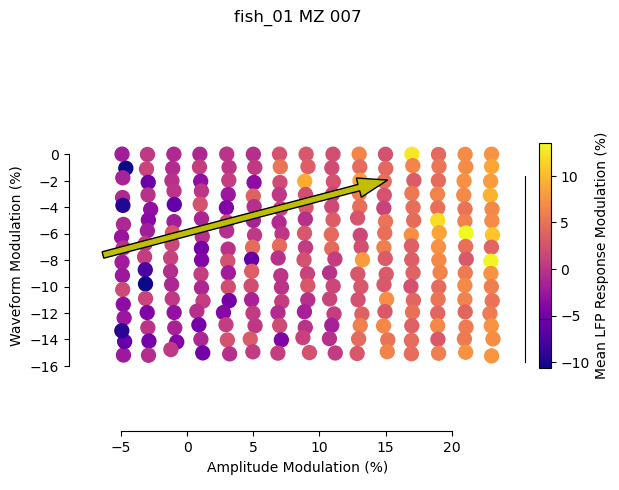

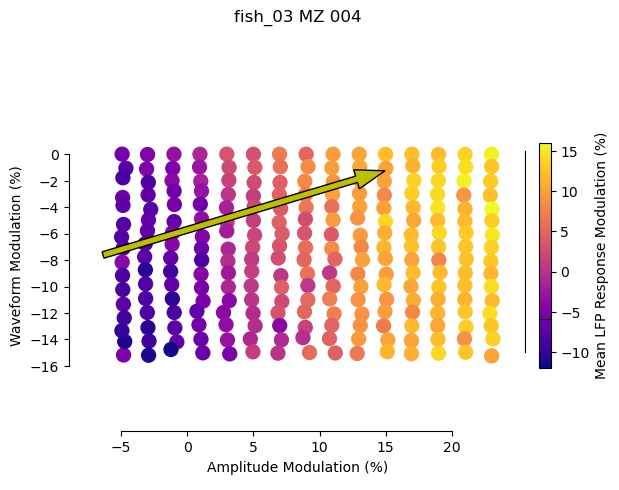

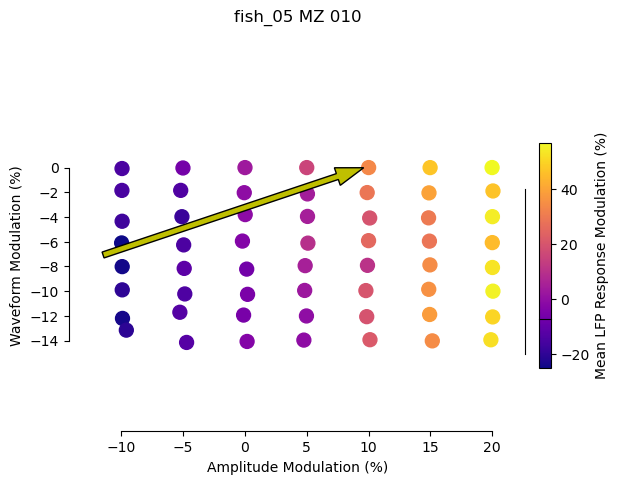

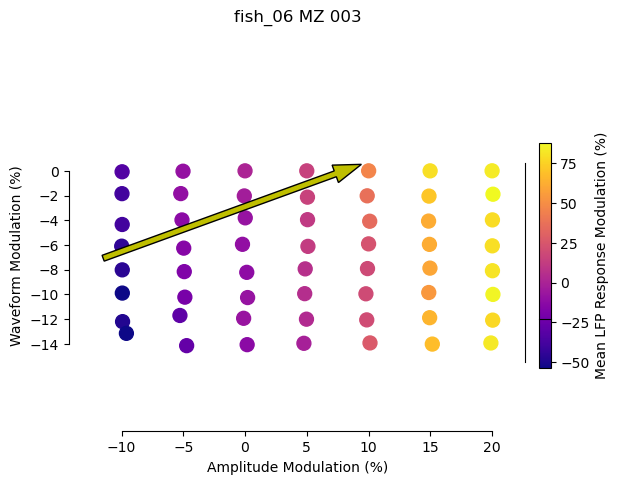

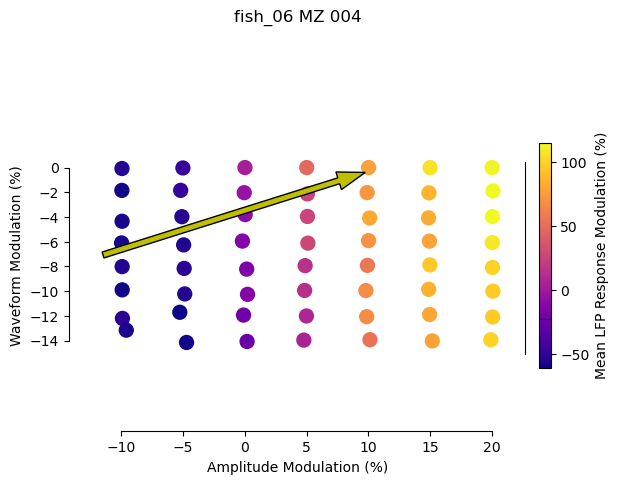

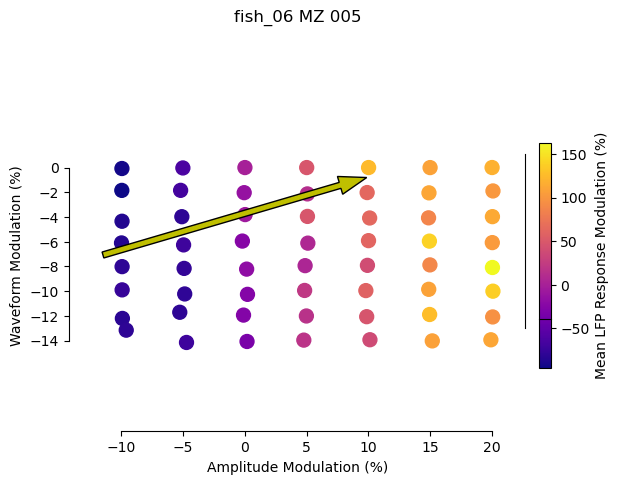

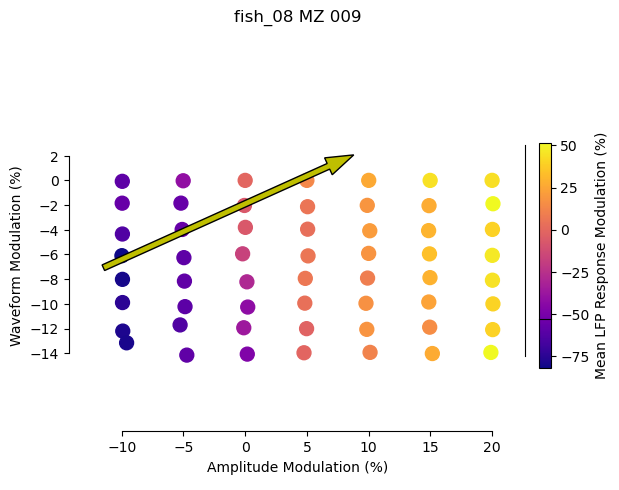

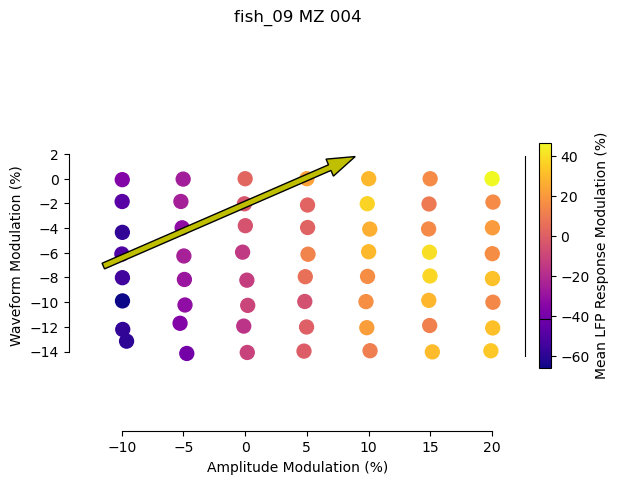

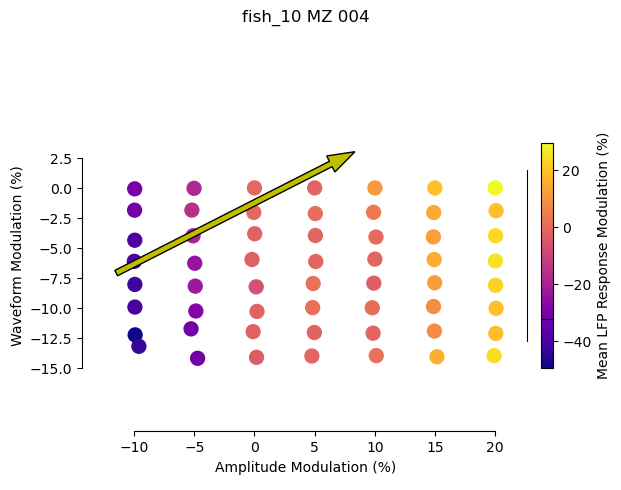

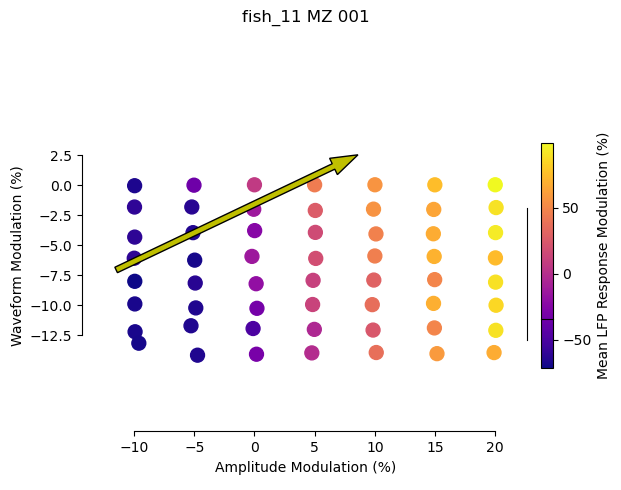

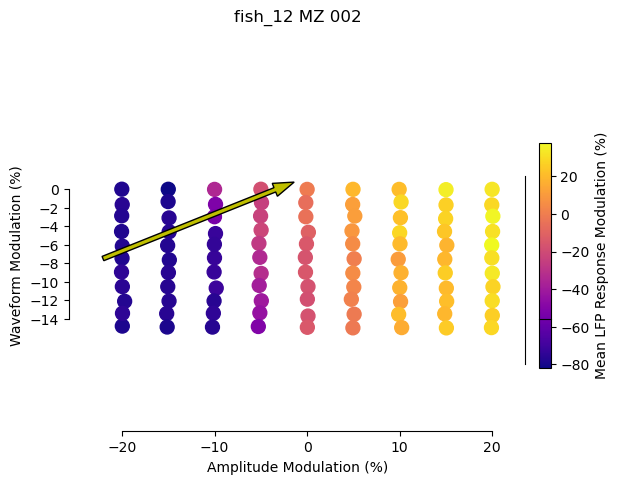

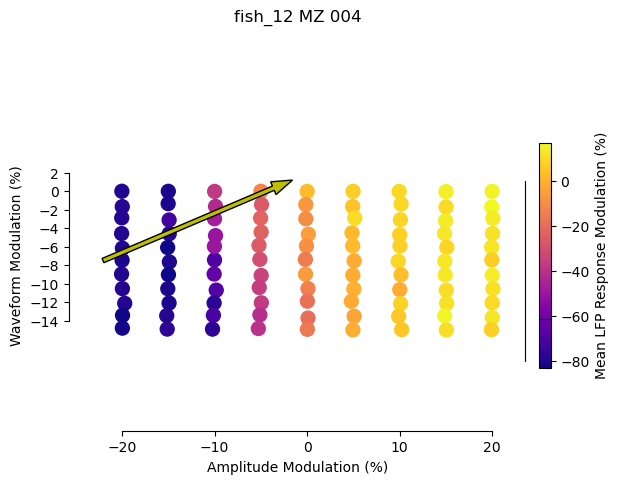

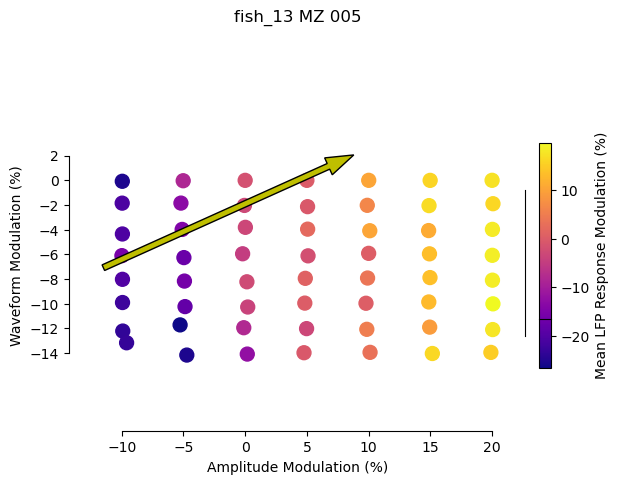

In [28]:
alignment_summary_pppn = lfp_data.groupby(["zone", "fish_id", "session_id"]).apply(plot_alignment_heatmap).reset_index()

In [29]:
alignment_summary_pppn["method"] = "pppn"
alignment_summary_pppn

zone  fish_id session_id  grad_angle  \
0   dlz  fish_01        009   74.370233   
1   dlz  fish_02        002   82.617504   
2   dlz  fish_03        001   71.234778   
3   dlz  fish_04        003   77.885967   
4   dlz  fish_06        008   87.073975   
5   dlz  fish_07        001   94.625128   
6   dlz  fish_09        010   87.649383   
7   dlz  fish_10        001   77.454938   
8   dlz  fish_11        001   80.085382   
9   dlz  fish_12        002   84.950526   
10  dlz  fish_12        004   87.057014   
11  dlz  fish_13        005   79.716658   
12   mz  fish_01        007   14.749107   
13   mz  fish_03        004   16.625543   
14   mz  fish_05        010   18.513742   
15   mz  fish_06        003   19.977907   
16   mz  fish_06        004   17.476902   
17   mz  fish_06        005   16.367346   
18   mz  fish_08        009   24.259096   
19   mz  fish_09        004   23.500057   
20   mz  fish_10        004   26.953947   
21   mz  fish_11        001   25.465499   
22   mz  fish_12        002   21.792134   
23   mz  fish_12        004   23.020851   
24   mz  fish_13        005   24.241729   

                                      grad_vec    reg_r2  \
0     [0.2694201762680018, 0.9630227248719102]  0.917858   
1    [0.12849262542128598, 0.9917104644059903]  0.875612   
2     [0.32169103235881696, 0.946844696716372]  0.927920   
3    [0.20985803723415705, 0.9777318672357096]  0.834961   
4     [0.0510465773010477, 0.9986962736216893]  0.892493   
5   [-0.08063607650195481, 0.9967436095437838]  0.533832   
6    [0.04101450497096567, 0.9991585511729292]  0.927416   
7     [0.2172073873007563, 0.9761254790763221]  0.901129   
8    [0.17218042702779532, 0.9850654295774093]  0.712076   
9     [0.0880159015500814, 0.9961190697272724]  0.439319   
10   [0.05134221047254805, 0.9986811189883348]  0.444487   
11   [0.17851616126501316, 0.9839369797742149]  0.812433   
12    [0.967049904961974, 0.25458688362332615]  0.662481   
13   [0.9581951185760151, 0.28611556185761033]  0.929544   
14    [0.9482475264560181, 0.3175320906145448]  0.955894   
15   [0.9398244333999191, 0.34165777378031525]  0.967929   
16    [0.9538380991196848, 0.3003212957280031]  0.965350   
17   [0.9594747331157103, 0.28179467083771526]  0.941205   
18   [0.9116968310786457, 0.41086358831266045]  0.945223   
19   [0.9170596811461155, 0.39874997331183026]  0.846264   
20   [0.8913711447832717, 0.45327417999237457]  0.903644   
21    [0.9028443552906512, 0.4299675221686031]  0.964331   
22     [0.928536804940567, 0.3712403559296368]  0.939138   
23    [0.9203625952591313, 0.3910660983106006]  0.898847   
24    [0.911821324176181, 0.41058722919447455]  0.946442   

                                           all_angles method  
0   [68.42432450678925, 76.07740863815714, 75.3025...   pppn  
1   [90.33885454706397, 86.32450097010424, 80.3951...   pppn  
2   [68.370848628631, 69.26445700143736, 73.033184...   pppn  
3   [74.55895023974901, 74.44207863626237, 75.2633...   pppn  
4   [88.6466546131948, 87.76454241110119, 87.95375...   pppn  
5   [93.2233686181538, 94.92753622959822, 94.37172...   pppn  
6   [85.11525071745466, 84.34992156009908, 88.6854...   pppn  
7   [84.95612813084877, 73.86917295173717, 68.1703...   pppn  
8   [80.77895780151317, 80.57984065681028, 84.0008...   pppn  
9   [101.03940682388134, 94.10721849134883, 92.600...   pppn  
10  [87.858567352211, 90.13719892225203, 91.118784...   pppn  
11  [85.28357252974072, 83.911248941463, 83.995894...   pppn  
12  [7.358495541118684, 15.81327566370222, 21.3624...   pppn  
13  [16.791047145480743, 23.402329664805283, 23.81...   pppn  
14  [14.805989731951282, 22.50050649083883, 25.780...   pppn  
15  [26.653515411809927, 19.417184340234826, 18.07...   pppn  
16  [4.070513301954738, 33.23265967963806, 31.7549...   pppn  
17  [0.3471889221427371, 30.644056167051335, 22.72...   pppn  
18  [25.732935243416758, 46.027062071918415, 30.71...   pppn  
19  [31.588549241690604, 44.04920134402652, 32.444...   pppn  


In [30]:
alignment_summary_pppn.groupby("zone").apply(
    lambda x: pd.Series(
        dict(
            angle_mean=x["grad_angle"].mean(),
            angle_std=x["grad_angle"].std(),
            reg_r2_avg=x["reg_r2"].mean(),
            method=x["method"].iloc[0],
        ),
    )
)

angle_mean  angle_std  reg_r2_avg method
zone                                          
dlz    82.060124   6.552149    0.768295   pppn
mz     20.995681   3.945371    0.912792   pppn

In [31]:
alignment_summary_pppn["all_angles"].apply(np.mean), 
alignment_summary_pppn.groupby("zone").apply(lambda x: x["all_angles"].apply(np.std).mean())

zone
dlz     4.235601
mz     11.512296
dtype: float64

## Show PCA from data stimuli

In [32]:
lfp_data = pd.read_pickle('../data/lfp-abby/processed/trial_averages.pkl')
select_stimuli = np.vstack(lfp_data[(lfp_data["fish_id"] == "fish_01") & (lfp_data["zone"] == "mz")]["waveform"]).T
base_stimulus = lfp_data["base_waveform"].iloc[0]
sampling_rate = lfp_data["stimulus_sampling_rate"].iloc[0]

In [33]:
stimuli_pca = PCA().fit(select_stimuli.T)
explained_variance = stimuli_pca.explained_variance_ratio_
components = stimuli_pca.components_[:2]
components[0] = -components[0]
components = components / components.max(1, keepdims=True)

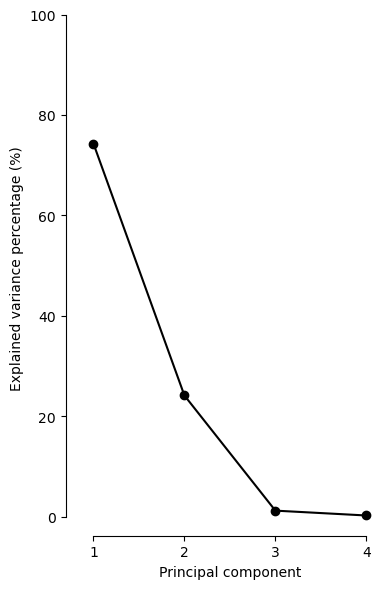

In [34]:
num_comp_to_plot = 4
plt.figure(figsize=(4, 6))
plt.plot(np.arange(num_comp_to_plot).astype(int)+1, explained_variance[:num_comp_to_plot]*100, "k", marker="o")
plt.xlabel("Principal component")
plt.ylabel("Explained variance percentage (%)")
plt.xticks(np.arange(num_comp_to_plot).astype(int)+1)
plt.ylim(-1,100.05)
sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.savefig("./panels/stimuli_pca_explained_variance.svg")
plt.show()

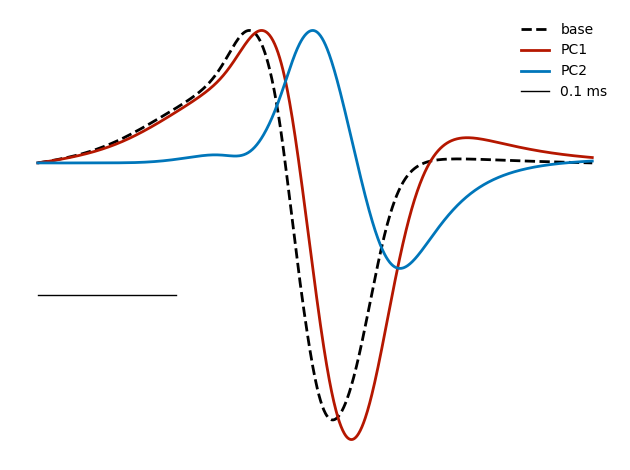

In [35]:
colors = ["#B51700", "#0076BA"]

plt.figure()
plt.plot(base_stimulus / base_stimulus.max(), color="k", ls="--", lw=2)
plt.plot(components[0], color=colors[0], lw=2)
plt.plot(components[1], color=colors[1], lw=2)
plt.plot([0, 0.1e-3 * sampling_rate], [-1, -1], "k", lw=1)
plt.legend(["base", "PC1", "PC2", "0.1 ms"], loc=1, frameon=False)
# plt.plot([0, 0], [-1, -1 + base_stimulus.ptp()/3], "k", lw=1)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.tight_layout()
plt.savefig("./panels/stimuli_pca_components.svg")
plt.show()

# Receptor Model

In [36]:
filters_models = pd.read_pickle("../filters-models/filters-models-by-fish-zone-session.pkl")

train_errors = filters_models[["input_noise_std", "train_error", "zone"]].copy()
train_errors["error"] = train_errors["train_error"]
train_errors.drop(columns="train_error", inplace=True)
train_errors["set"] = "train"

valid_errors = filters_models[["input_noise_std", "valid_error", "zone"]].copy()
valid_errors["error"] = valid_errors["valid_error"]
valid_errors.drop(columns="valid_error", inplace=True)
valid_errors["set"] = "valid"

filters_models_errors = pd.concat(
    [train_errors, valid_errors],
    axis=0,
    ignore_index=True,
)

## Schematic

Draw the schematic separately in drawing apps.

## Validation error as function of input noise STD

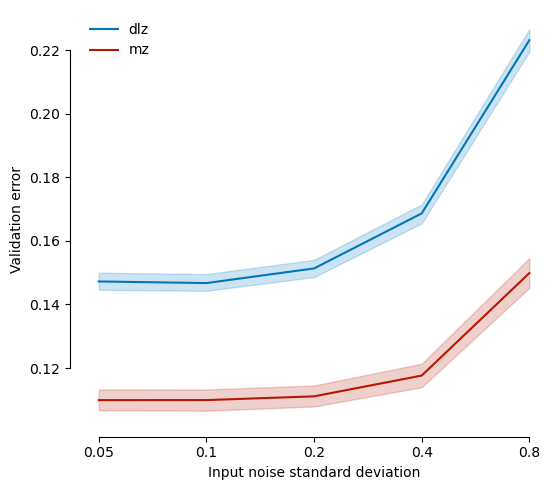

In [37]:
snsplot = sns.relplot(data=valid_errors, x="input_noise_std", y="error", hue="zone", kind="line", palette=dict(mz="#B51700", dlz="#0076BA"))
snsplot.legend.remove()
plt.xlabel("Input noise standard deviation")
plt.ylabel("Validation error")
plt.xscale("log")
plt.legend(loc=2, frameon=False)
plt.minorticks_off()
plt.xticks(valid_errors["input_noise_std"].unique(), valid_errors["input_noise_std"].unique())
sns.despine(offset=5, trim=True)
plt.tight_layout()
plt.savefig("./panels/filters_valid_error_with_input_noise.svg")
plt.show()

## True vs predicted LFP

In [38]:
lfp_data = pd.read_pickle("../data/lfp-abby/processed/single_trials.pkl")
conv_filters = filters_models[filters_models["input_noise_std"] == 0.4]

In [39]:
def compute_single_model_prediction(model_row, waveforms):
    conv_filter = model_row["model_filter"]
    conv_bias = model_row["model_bias"]
    bn_mean = model_row["bn_mean"]
    bn_var = model_row["bn_var"]
    bn_weight = model_row["bn_weight"]
    bn_bias = model_row["bn_bias"]

    responses = (conv_bias + np.dot(waveforms, conv_filter) - bn_mean) / np.sqrt(bn_var + 1e-10) * bn_weight + bn_bias

    return responses


def compute_prediction(dfgroup, conv_filters=conv_filters):
    fish_id = dfgroup["fish_id"].iloc[0]
    zone = dfgroup["zone"].iloc[0]
    waveforms = np.vstack(dfgroup["waveform"])
    best_model_idx = conv_filters[(conv_filters["zone"] == zone) & (conv_filters["fish_id"] == fish_id)][
        "train_error"  # "valid_error"
    ].idxmin()
    modulations = compute_single_model_prediction(conv_filters.loc[best_model_idx], waveforms)
    return modulations

In [40]:
true_values = lfp_data.groupby(["fish_id", "zone"]).apply(lambda x: x["lfp_response_modulation"].to_numpy()).rename("true").reset_index()
predicted_values = (
    lfp_data.groupby(["fish_id", "zone"]).apply(compute_prediction).rename("predicted").reset_index()
)
true_vs_predicted = pd.merge(true_values, predicted_values, on=["fish_id", "zone"])

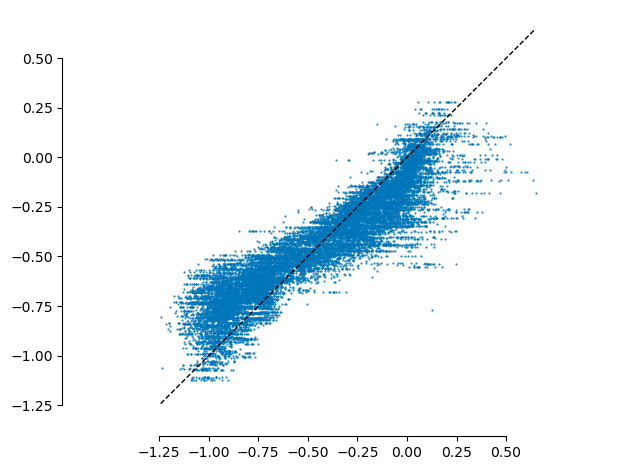

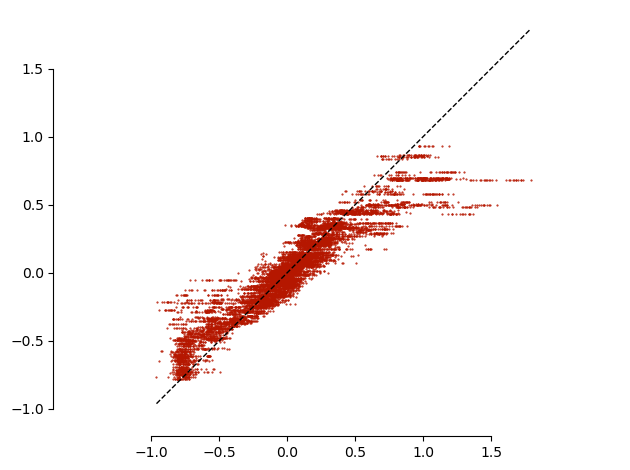

Empty DataFrame
Columns: []
Index: []

In [41]:
def plot_true_vs_predicted(dfgroup, colors=dict(mz="#B51700", dlz="#0076BA")):
    zone = dfgroup["zone"].iloc[0]
    xs = np.hstack(dfgroup["true"])
    ys = np.hstack(dfgroup["predicted"])
    plt.figure()
    plt.scatter(xs, ys, c=colors[zone], s=1, marker=".")
    plt.plot([xs.min(), xs.max()], [xs.min(), xs.max()], "k--", lw=1)
    plt.axis("equal")
    sns.despine(offset=10, trim=True)
    plt.tight_layout()
    plt.savefig(f"./panels/true_vs_predicted_{zone}.svg")
    plt.savefig(f"./panels/true_vs_predicted_{zone}.png", dpi=1000)
    plt.show()
    pass


true_vs_predicted.groupby("zone").apply(plot_true_vs_predicted)

## Conv filters

In [42]:
smooth_filters = pd.read_pickle("../data/filters/smooth-filters-all.pkl")
input_noise_std=0.4
sampling_rate = sampling_rate  # defined above

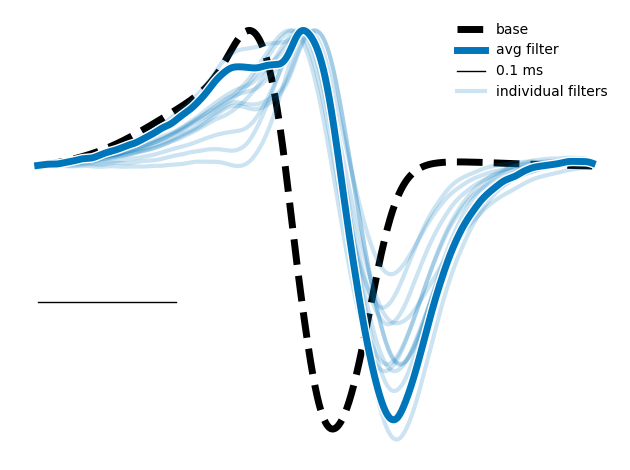

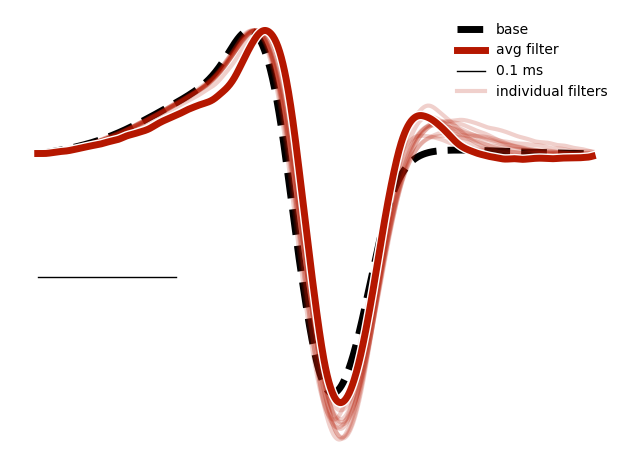

Empty DataFrame
Columns: []
Index: []

In [43]:
def plot_conv_filters(
    dfgroup,
    colors=dict(mz="#B51700", dlz="#0076BA"),
    sampling_rate=sampling_rate,
    base_stimulus=base_stimulus / base_stimulus.max(),
):
    zone = dfgroup["zone"].iloc[0]
    input_noise_std = f"{dfgroup['input_noise_std'].iloc[0]:.2f}".replace(".", "p")
    avg_filter = dfgroup[dfgroup["fish_id"] == "fish"]["model_filter"].iloc[0]
    individual_filters = np.vstack(dfgroup[dfgroup["fish_id"] != "fish"]["model_filter"])

    plt.figure()
    plt.plot(base_stimulus, "k", ls="--", lw=5, zorder=0)
    plt.plot(avg_filter, color=colors[zone], lw=5)
    plt.plot([0, 0.1e-3 * sampling_rate], [-1, -1], "k", lw=1)
    plt.plot(individual_filters.T, color=colors[zone], lw=3, alpha=0.2, zorder=0)
    plt.plot(avg_filter, color="w", lw=7, zorder=1)
    plt.legend(["base", "avg filter", "0.1 ms", "individual filters"], loc=1, frameon=False)
    plt.xticks([])
    plt.yticks([])
    plt.box(False)
    plt.tight_layout()
    plt.savefig(f"./panels/filters_waveform_{zone}_{input_noise_std}.svg")
    if input_noise_std == "0p40":
        plt.show()
    plt.close()
    pass


smooth_filters.groupby(["zone", "input_noise_std"]).apply(plot_conv_filters)

## Alignment with conv. features

In [44]:
lfp_data = pd.read_pickle("../data/lfp-abby/processed/trial_averages.pkl")
cmap = plt.cm.plasma  # type: ignore
conv_filters = filters_models[filters_models["input_noise_std"] == 0.4]

In [46]:
def plot_alignment_heatmap_conv_feats(
    dfgroup, cmap=cmap, inverse_arrow_length=0.1, arrow_width=0.5, conv_filters=conv_filters, num_bins=6
):
    fish_id = dfgroup["fish_id"].iloc[0]
    zone = dfgroup["zone"].iloc[0]
    session_id = dfgroup["session_id"].iloc[0]
    waveforms = np.vstack(dfgroup["waveform"])
    responses = dfgroup["mean_lfp_response_modulation"] * 100
    color_norm = mpl.colors.Normalize(vmin=responses.min(), vmax=responses.max())  # type: ignore
    if (
        "mz" in conv_filters[conv_filters["fish_id"] == fish_id]["zone"].unique()
        and "dlz" in conv_filters[conv_filters["fish_id"] == fish_id]["zone"].unique()
    ):
        target_angle = 0 if zone == "mz" else 90
        angle_error = np.inf
        conv_filters_mz = conv_filters[(conv_filters["fish_id"] == fish_id) & (conv_filters["zone"] == "mz")]
        conv_filters_dlz = conv_filters[(conv_filters["fish_id"] == fish_id) & (conv_filters["zone"] == "dlz")]
        for i, conv_mz_row in conv_filters_mz.iterrows():
            for j, conv_dlz_row in conv_filters_dlz.iterrows():
                xs = compute_single_model_prediction(conv_mz_row, waveforms) * 100
                ys = compute_single_model_prediction(conv_dlz_row, waveforms) * 100

                reg = LinearRegression().fit(np.stack([xs, ys]).T, responses)

                xs_bins = np.linspace(xs.min(), xs.max(), num_bins+1)
                gradients_ys = []
                for x_min, x_max in zip(xs_bins[:-1], xs_bins[1:]):
                    mask = (xs >= x_min) & (xs < x_max)
                    gradients_ys.append(np.polyfit(ys[mask], responses[mask], 1)[0])

                ys_bins = np.linspace(ys.min(), ys.max(), num_bins+1)
                gradients_xs = []
                for y_min, y_max in zip(ys_bins[:-1], ys_bins[1:]):
                    mask = (ys >= y_min) & (ys < y_max)
                    gradients_xs.append(np.polyfit(xs[mask], responses[mask], 1)[0])

                grad_vec = np.array([np.mean(gradients_xs), np.mean(gradients_ys)])
                grad_angle = np.arctan2(grad_vec[1], grad_vec[0]) * 360 / (2 * np.pi)

                if np.abs(grad_angle - target_angle) < angle_error:
                    angle_error = np.abs(grad_angle - target_angle)
                    best_model_mz_idx = i
                    best_model_dlz_idx = j
                    best_reg = reg
                    best_grad_vec = grad_vec

        xs = compute_single_model_prediction(conv_filters.loc[best_model_mz_idx], waveforms) * 100
        ys = compute_single_model_prediction(conv_filters.loc[best_model_dlz_idx], waveforms) * 100
        reg = best_reg
        grad_vec = best_grad_vec / np.linalg.norm(best_grad_vec)

        fig = plt.figure()
        plt.scatter(xs, ys, c=cmap(color_norm(responses)), s=100, marker="o")
        cbar = fig.colorbar(
            plt.cm.ScalarMappable(norm=color_norm, cmap=cmap),
            ax=plt.gca(),
            shrink=0.5,
            label="Mean LFP Response Modulation (%)",
        )
        sns.despine(ax=cbar.ax, left=False, bottom=False)
        x0, y0 = 0, 0
        if zone == "mz":
            x0 = plt.gca().get_xlim()[0]
            y0 = np.mean(plt.gca().get_ylim())
            inverse_arrow_length /= 2
        elif zone == "dlz":
            x0 = np.mean(plt.gca().get_xlim())
            y0 = plt.gca().get_ylim()[0]
        plt.arrow(
            x0,  # type: ignore
            y0,  # type: ignore
            grad_vec[0] / inverse_arrow_length,
            grad_vec[1] / inverse_arrow_length,
            facecolor="y",
            width=arrow_width,
            edgecolor="k",
            lw=1,
        )
        sns.despine(offset=10, trim=True)
        # plt.axis("equal")
        plt.tight_layout()
        plt.title(f"{fish_id} {zone.upper()} {session_id}")
        plt.savefig(f"./panels/response_heatmap_conv_feats-{zone}-{fish_id}-{session_id}.svg")
        plt.show()
        return pd.Series(
            dict(
                grad_angle=np.arctan2(grad_vec[1], grad_vec[0]) * 360 / (2 * np.pi),
                grad_vec=grad_vec,
                reg_r2=reg.score(np.stack([xs, ys]).T, responses),
                all_angles=np.arctan2(gradients_ys, gradients_xs) * 360 / (2 * np.pi),
            )
        )

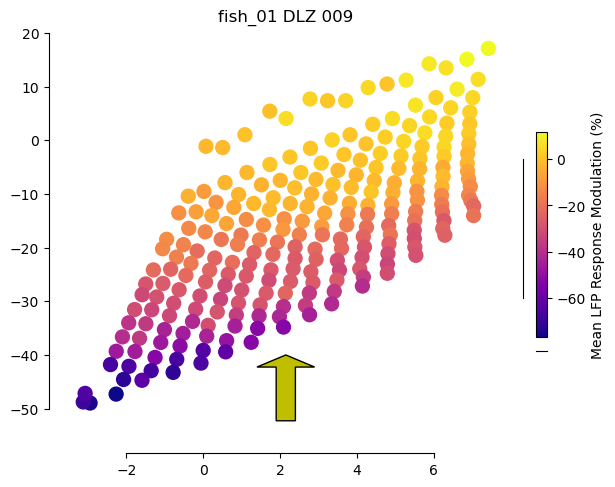

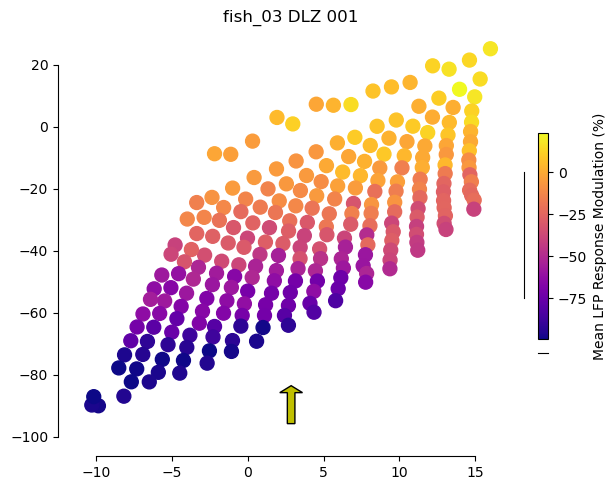

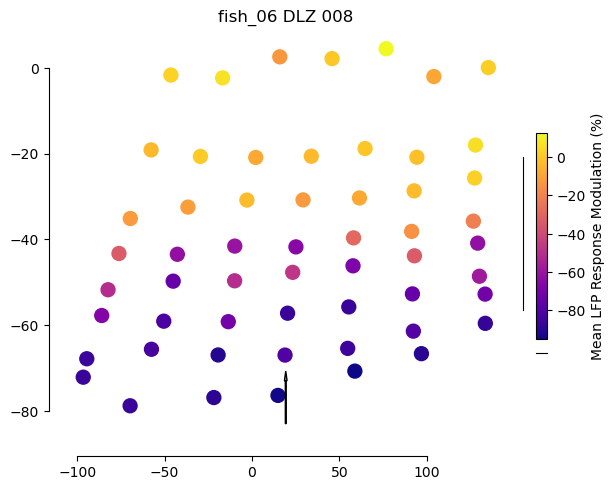

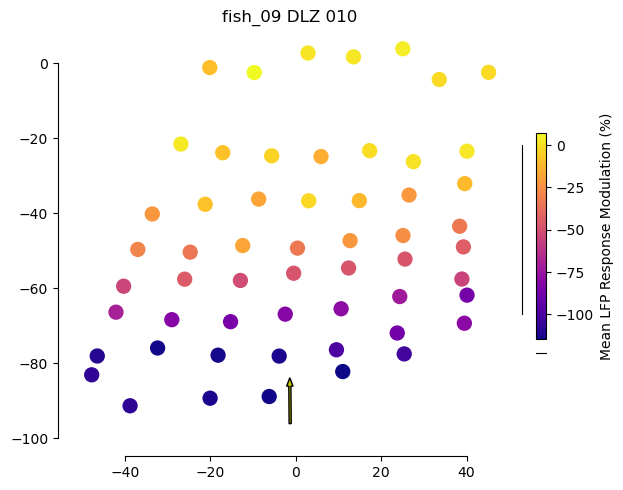

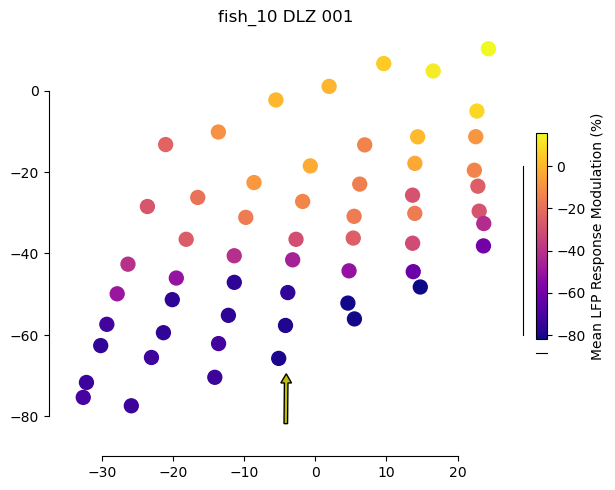

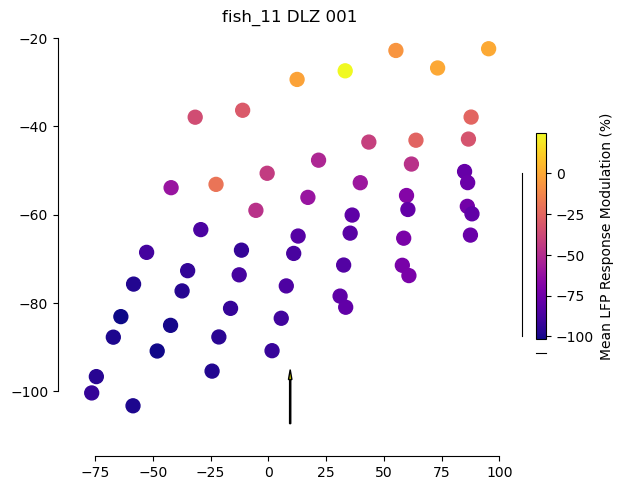

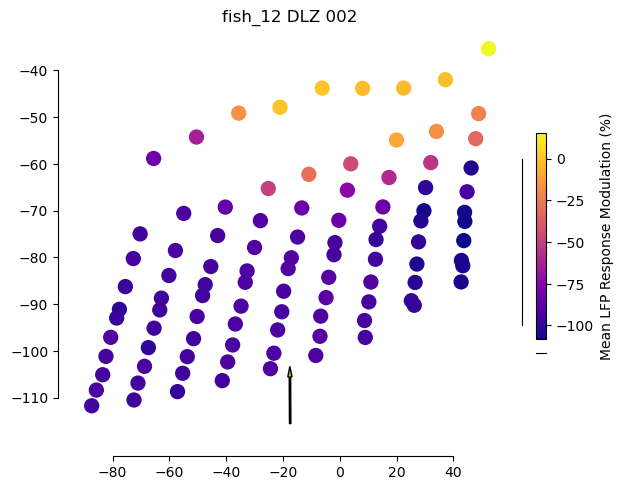

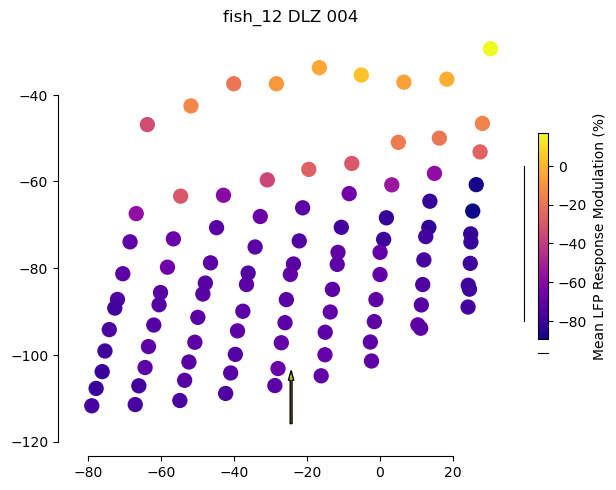

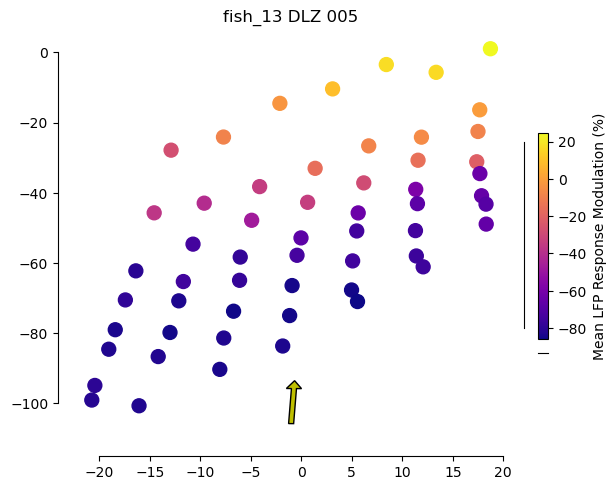

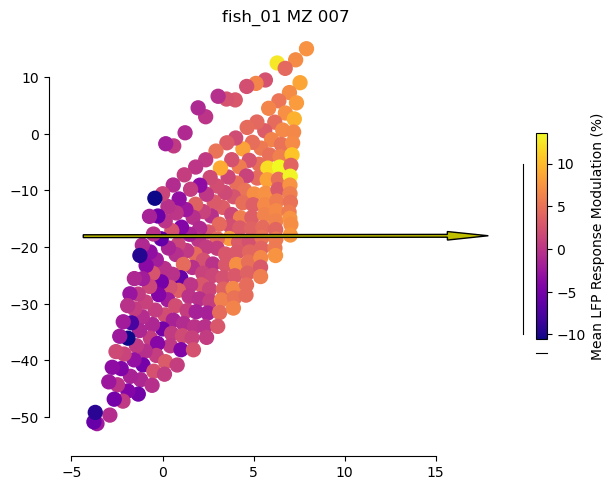

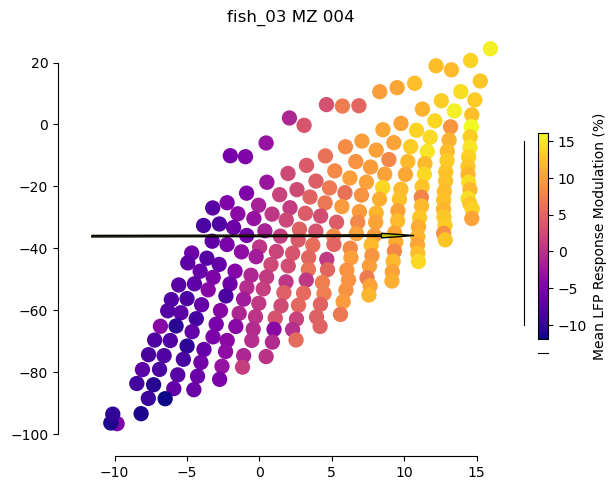

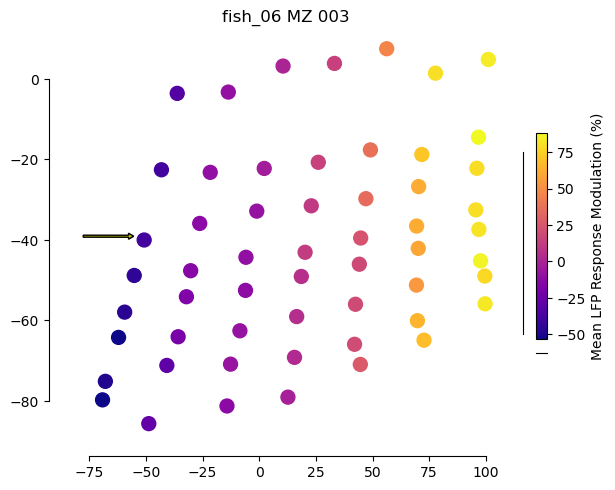

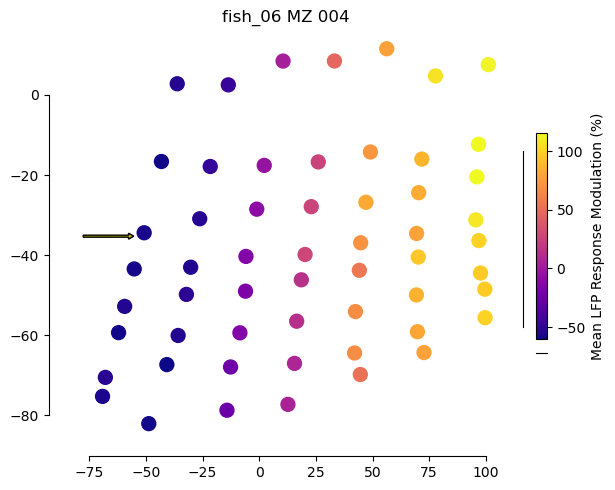

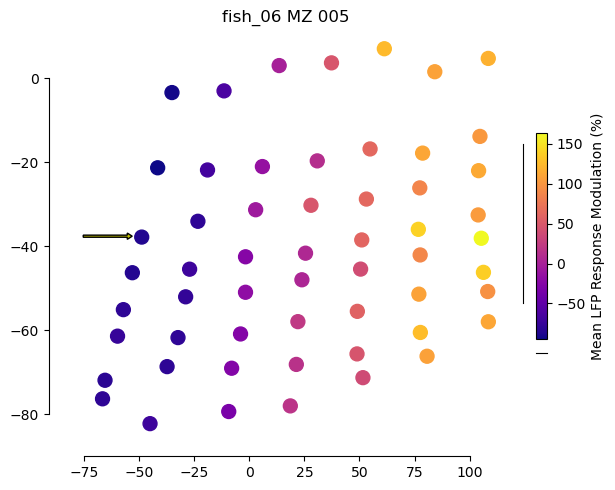

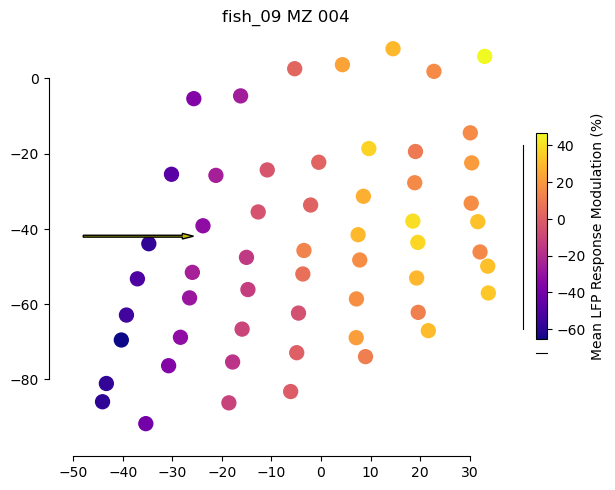

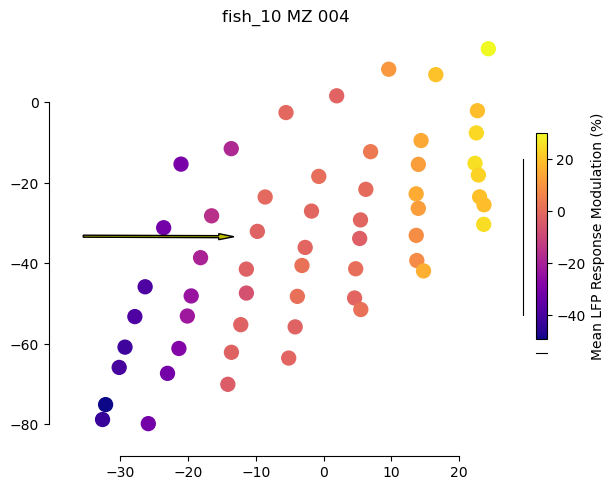

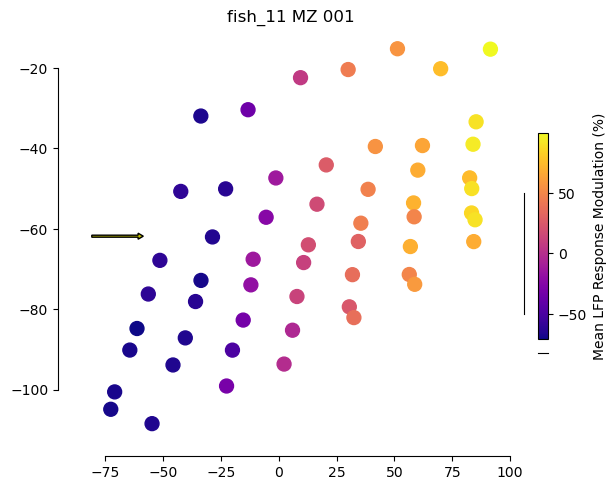

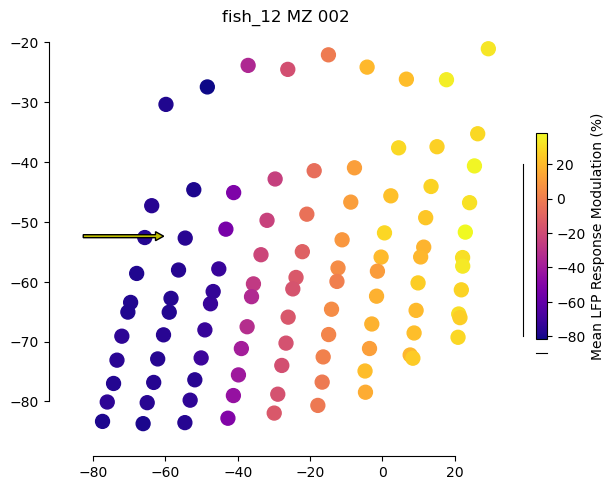

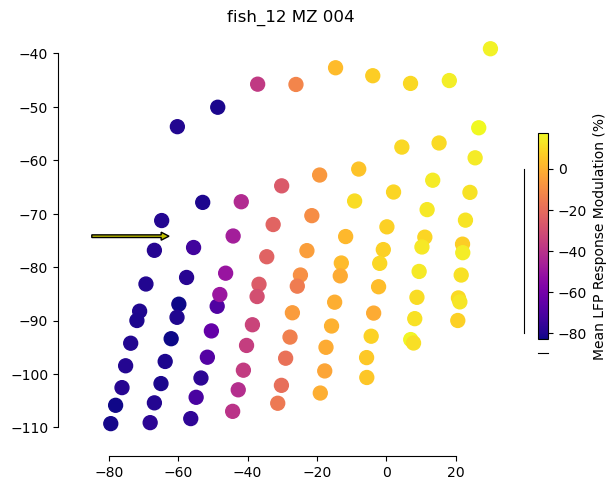

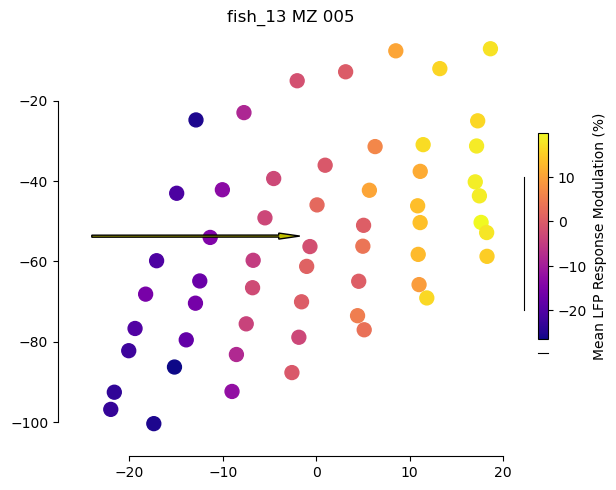

In [47]:
alignment_summary_convfeats = lfp_data.groupby(["zone", "fish_id", "session_id"]).apply(plot_alignment_heatmap_conv_feats).dropna(axis=0).reset_index()

In [48]:
alignment_summary_convfeats["method"] = "conv_feats"
alignment_summary_convfeats

zone  fish_id session_id  grad_angle  \
0   dlz  fish_01        009   90.000345   
1   dlz  fish_03        001   89.991568   
2   dlz  fish_06        008   90.124036   
3   dlz  fish_09        010   90.416523   
4   dlz  fish_10        001   89.692536   
5   dlz  fish_11        001   89.929652   
6   dlz  fish_12        002   90.504951   
7   dlz  fish_12        004   90.000077   
8   dlz  fish_13        005   88.388376   
9    mz  fish_01        007    0.202565   
10   mz  fish_03        004    0.558294   
11   mz  fish_06        003   -0.020721   
12   mz  fish_06        004    0.009501   
13   mz  fish_06        005   -0.000369   
14   mz  fish_09        004    0.002788   
15   mz  fish_10        004   -0.339696   
16   mz  fish_11        001    0.003440   
17   mz  fish_12        002   -0.000406   
18   mz  fish_12        004    0.000633   
19   mz  fish_13        005    0.082893   

                                         grad_vec    reg_r2  \
0   [-6.0237424205055005e-06, 0.9999999999818572]  0.896527   
1    [0.00014716573019920762, 0.9999999891711238]  0.927586   
2    [-0.0021648286374607566, 0.9999976567557398]  0.838500   
3     [-0.007269636867017802, 0.9999735758407927]  0.855670   
4       [0.005366225152859366, 0.999985601710149]  0.862920   
5       [0.001227809948531336, 0.999999246241081]  0.797548   
6      [-0.00881293700739671, 0.9999611653165856]  0.576075   
7     [-1.352150119205397e-06, 0.999999999999086]  0.616479   
8      [0.028124440769795183, 0.9996044296777532]  0.837915   
9     [0.9999937503767286, 0.0035354218256015125]  0.657130   
10      [0.9999525270155338, 0.00974390657016865]  0.926574   
11   [0.9999999346029307, -0.0003616547171295032]  0.967061   
12   [0.9999999862507261, 0.00016582686093355166]  0.955993   
13   [0.9999999999792483, -6.442334241989497e-06]  0.935857   
14    [0.9999999988159051, 4.866404925520147e-05]  0.858755   
15     [0.9999824246088252, -0.00592878347176424]  0.911291   
16    [0.9999999981974105, 6.004314375884186e-05]  0.958913   
17    [0.999999999974899, -7.085348735758081e-06]  0.938050   
18   [0.9999999999390039, 1.1045011262008638e-05]  0.896988   
19    [0.9999989534369216, 0.0014467636509757772]  0.947888   

                                           all_angles      method  
0   [46.27219764786893, 113.93506938087755, 129.43...  conv_feats  
1   [84.09774502537226, 114.53530284869188, 100.23...  conv_feats  
2   [91.64800791356988, 94.67444307013493, 91.5195...  conv_feats  
3   [95.0635890863276, 109.99810923700613, 110.855...  conv_feats  
4   [104.29012844592054, 106.9832988500457, 101.11...  conv_feats  
5   [74.90088586805663, 78.64423133833004, 82.2592...  conv_feats  
6   [82.6315291748073, 97.56256470019555, 94.39119...  conv_feats  
7   [81.85149072972699, 90.17861434301393, 95.7699...  conv_feats  
8   [164.4305314698827, 98.78638506154086, 81.5537...  conv_feats  
9   [3.5320543028948874, -3.0038873609387022, -1.4...  conv_feats  
10  [4.865838047423701, 0.019374230253772818, -0.7...  conv_feats  
11  [5.424297283232349, 0.7269805210650852, 6.1984...  conv_feats  
12  [-3.689347136201522, -6.523786453081771, 8.789...  conv_feats  
13  [-19.47677212470625, -13.234786323714895, 2.10...  conv_feats  
14  [-4.2443174789300775, -8.792055081504008, -9.4...  conv_feats  
15  [-0.054567821899893544, -15.603453569751572, -...  conv_feats  
16  [8.946378817669416, -15.905007699085527, -4.79...  conv_feats  
17  [-0.392015089822025, -2.4337510595802385, 1.13...  conv_feats  
18  [0.8097938964321866, -2.8296549216415077, 1.08...  conv_feats  
19  [8.535407818334276, -4.8530322290218235, -1.91...  conv_feats

In [49]:
alignment_summary_convfeats.groupby("zone").apply(
    lambda x: pd.Series(
        dict(
            angle_mean=x["grad_angle"].mean(),
            angle_std=x["grad_angle"].std(),
            reg_r2_avg=x["reg_r2"].mean(),
            method=x["method"].iloc[0],
        )
    )
)

angle_mean  angle_std  reg_r2_avg      method
zone                                               
dlz    89.894229   0.616447    0.801024  conv_feats
mz      0.045357   0.212814    0.904954  conv_feats

In [51]:
alignment_summary_convfeats.groupby("zone").apply(lambda x: (x["all_angles"].apply(np.std).mean(), x["all_angles"].apply(np.mean).mean()))

zone
dlz    (16.438249889170624, 91.39952025120402)
mz     (5.519044200434471, 0.4582990340887527)
dtype: object

## Alignment summary plot

In [54]:
alignment_summary = pd.concat([alignment_summary_pppn, alignment_summary_convfeats], axis=0, names=["pppn", "convfeats"], ignore_index=True)

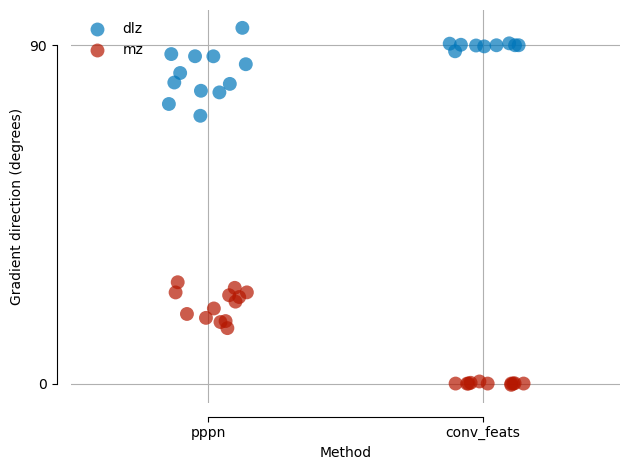

In [55]:
f = plt.figure()
colors = ["#B51700", "#0076BA"]
sns.stripplot(
    data=alignment_summary,
    x="method",
    y="grad_angle",
    hue="zone",
    s=10,
    alpha=0.7,
    palette=dict(mz="#B51700", dlz="#0076BA"),
    dodge=False,
    jitter=0.15,
)
plt.yticks([0, 90])
plt.legend(loc=2, frameon=False)
plt.xlabel("Method")
plt.ylabel("Gradient direction (degrees)")
plt.grid(True)
sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.savefig("./panels/alignment_summary_scatter.svg")
plt.show()

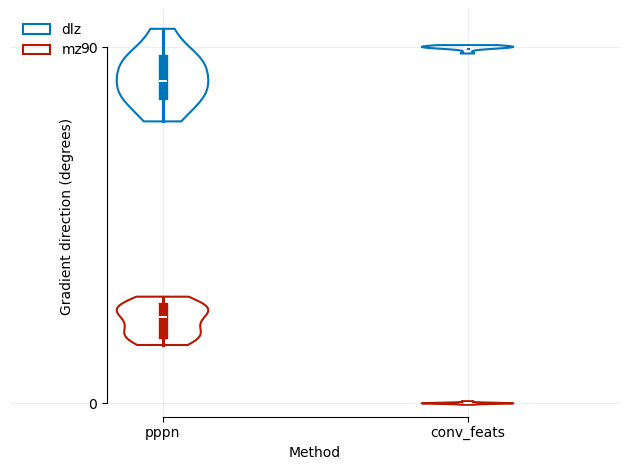

In [56]:
f = plt.figure()
colors = ["#B51700", "#0076BA"]
sns.violinplot(
    data=alignment_summary,
    x="method",
    y="grad_angle",
    hue="zone",
    palette=dict(mz="#B51700", dlz="#0076BA"),
    cut=0,
    split=False,
    inner="box",
    fill=False,
    dodge=False,
    width=0.3,
    density_norm="width",
)
plt.yticks([0, 90])
plt.legend(loc=2, frameon=False)
plt.xlabel("Method")
plt.ylabel("Gradient direction (degrees)")
sns.despine(offset=dict(left=-70, bottom=-5), trim=True)
plt.grid(True, alpha=0.2, zorder=-1)
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.savefig("./panels/alignment_summary_violin.svg")
plt.show()

## Adaptation panel

In [44]:
# select a model
filters_models = pd.read_pickle("../filters-models/filters-models-by-fish-zone-session.pkl")
model_idx = filters_models[
    (filters_models["input_noise_std"] == 0.4) & (filters_models["zone"] == "mz")
].valid_error.idxmin()
model_row = filters_models.loc[model_idx]
model_path = f"../filters-models/trained-by-fish-zone-session/{model_row['fish_id']}-{model_row['zone']}-{model_row['session_id']}-{str(model_row['input_noise_std']).replace('.','p')}/version_{model_row['model_id']}/checkpoints/*"
model_path = glob.glob(model_path)
assert len(model_path) == 1, "there should be only one model file"
model_path = model_path[0]
model = ConvMormyromast(
    input_length=base_stimulus.shape[0],
    input_channels=1,
    conv_layer_fraction_widths=[1],
    conv_output_channels=1,
    conv_stride=25,
    N_receptors=1,
)
model_state_dict = torch.load(model_path, map_location=torch.device("cpu"))["state_dict"]
new_model_state_dict = {}
for k, v in model_state_dict.items():
    new_model_state_dict[k[6:]] = v
model.load_state_dict(new_model_state_dict)
model.init_adaptation_values_from_BatchNorm()
model.adapt_coeff = (1-0.9997) / 2
model.eval()

# load the data
lfp_data = pd.read_pickle("../data/lfp-abby/processed/single_trials.pkl")
lfp_data = create_train_and_validation_datasets(
    lfp_data, fish_id=model_row["fish_id"], zone=model_row["zone"], session_id=model_row["session_id"], percent_train=1
)
lfp_data_loader = DataLoader(lfp_data, batch_size=100, shuffle=True, drop_last=True)
errors = []
for i in range(100):
    xs, ys = next(iter(lfp_data_loader))
    ys = ys.numpy().flatten()
    if i >= 60:
        xs = xs * 2
    elif i >= 20:
        xs = xs / 2
    
    with torch.no_grad():
        predictions = model(xs, mode="adaptive").detach().cpu().numpy().flatten()
    errors.append(predictions - ys)
    # errors.append(np.abs(predictions - ys))
errors = np.hstack(errors)

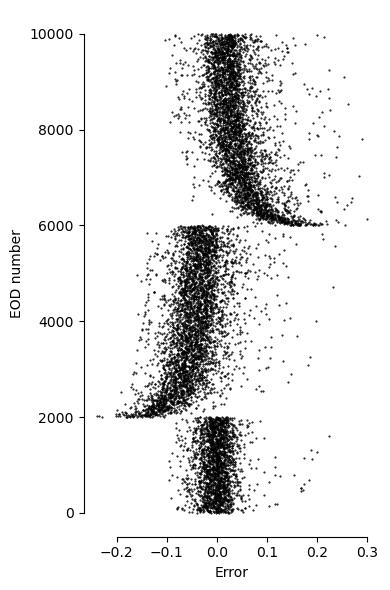

In [45]:
plt.figure(figsize=(4, 6))
plt.scatter(errors, np.arange(errors.shape[0]) + 1, c="k", marker=".", s=1)
plt.xlabel("Error")
plt.ylabel("EOD number")
sns.despine(offset=0, trim=True)
plt.tight_layout()
plt.savefig("./panels/adaptation.svg")
plt.show()

# Miscellaneous

## inspect gradient direction in alignment plots

In [46]:
lfp_data = pd.read_pickle("../data/lfp-abby/processed/trial_averages.pkl")
fish_id = "fish_01"
zone = "dlz"
dfgroup = lfp_data[(lfp_data["fish_id"] == fish_id) & (lfp_data["zone"] == zone)]
waveforms = np.vstack(dfgroup["waveform"])
conv_filters = filters_models[filters_models["input_noise_std"] == 0.4]

best_model_mz_idx = conv_filters[(conv_filters["fish_id"] == fish_id) & (conv_filters["zone"] == "mz")][
    "valid_error"
].idxmin()
best_model_dlz_idx = conv_filters[(conv_filters["fish_id"] == fish_id) & (conv_filters["zone"] == "dlz")][
    "valid_error"
].idxmin()
xs = compute_single_model_prediction(conv_filters.loc[best_model_mz_idx], waveforms) * 100
ys = compute_single_model_prediction(conv_filters.loc[best_model_dlz_idx], waveforms) * 100
responses = dfgroup["mean_lfp_response_modulation"] * 100

# keep_ids = np.where((ys < 0) & (ys > -50))[0]
# xs = xs[keep_ids]
# ys = ys[keep_ids]
# responses = responses.iloc[keep_ids]

reg = LinearRegression().fit(np.stack([xs, ys]).T, responses)
grad_vec = reg.coef_ / np.linalg.norm(reg.coef_)
print(grad_vec, np.arctan2(grad_vec[1], grad_vec[0]) * 360 / (2 * np.pi), reg.score(np.stack([xs, ys]).T, responses))

fig = px.scatter_3d(x=xs, y=ys, z=responses, color=responses, opacity=0.5)
# fig = px.scatter(x=xs, y=ys, color=responses, opacity=0.5)
fig.update_traces(marker_size = 5)
fig.update_layout(width=500, height=500)
fig.show()

[-0.49984072  0.86611734] 119.98946280387588 0.8963571335799561


In [47]:
responses = ys
reg2 = LinearRegression().fit(np.stack([xs, ys]).T, responses)
grad_vec = reg2.coef_ / np.linalg.norm(reg2.coef_)
print(grad_vec, np.arctan2(grad_vec[1], grad_vec[0]) * 360 / (2 * np.pi), reg2.score(np.stack([xs, ys]).T, responses))

fig = px.scatter(x=xs, y=ys, color=responses, opacity=0.5)
fig.update_traces(marker_size = 15)
fig.update_layout(width=500, height=500)
fig.show()

[-1.30164141e-15  1.00000000e+00] 90.00000000000007 1.0
